C:\Users\dylan\AppData\Local\Temp\ipykernel_31488\2466863306.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  users['adopted'] = users['object_id'].map(adopted_status).fillna(False).astype(int)
C:\Users\dylan\AppData\Local\Temp\ipykernel_31488\2466863306.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=importances.index, palette='viridis')


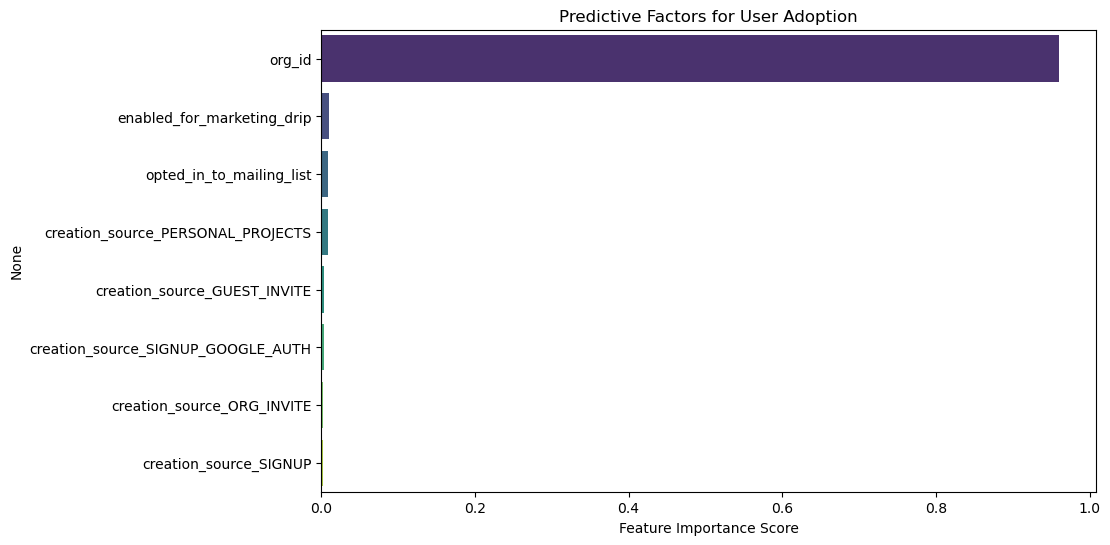

Model Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      2069
           1       0.22      0.12      0.16       331

    accuracy                           0.82      2400
   macro avg       0.54      0.53      0.53      2400
weighted avg       0.78      0.82      0.80      2400



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# 1. LOAD DATA
# Using latin-1 encoding for users as it often contains special characters
users = pd.read_csv('takehome_users.csv', encoding='latin-1')
engagement = pd.read_csv('takehome_user_engagement.csv')

# 2. IDENTIFY ADOPTED USERS
# Definition: 3 logins on separate days in at least one 7-day period
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])

def check_adoption(group):
    """Checks for 3 logins within any rolling 7-day window"""
    # Floor to day and drop duplicates to ensure 'separate days'
    group = group.dt.floor('D').drop_duplicates().sort_values()
    if len(group) < 3:
        return False
    # Check if the difference between current login and the one 2 positions back is <= 7 days
    return any(group.diff(periods=2).dt.days <= 7)

adopted_status = engagement.groupby('user_id')['time_stamp'].apply(check_adoption)
users['adopted'] = users['object_id'].map(adopted_status).fillna(False).astype(int)

# 3. FEATURE ENGINEERING
# Drop high-cardinality identifiers (names/emails)
X = users.drop(['object_id', 'name', 'email', 'creation_time', 
                'last_session_creation_time', 'invited_by_user_id', 'adopted'], axis=1)

# One-hot encode creation_source
X = pd.get_dummies(X, columns=['creation_source'])
y = users['adopted']

# 4. PREDICTIVE MODELING (Random Forest)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 5. RESULTS & VISUALIZATION
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=importances.index, palette='viridis')
plt.title('Predictive Factors for User Adoption')
plt.xlabel('Feature Importance Score')
plt.show()

print("Model Classification Report:")
print(classification_report(y_test, rf.predict(X_test)))